In [1]:
# import topopy
from test_functions import *
# import matplotlib.pyplot as plt
# import samplers
# import seaborn as sns
# from matplotlib import patches, collections
import numpy as np
from ipywidgets import interact, HTML
import random
import pdir

In [2]:
from sidepanel import SidePanel

import ipywidgets as widgets

from regulus.utils import io
from regulus.topo import * 
from regulus.alg import *
from regulus.measures import *
from regulus.models import *
from regulus.tree import *

from ipyregulus import TreeWidget, TreeView, DetailsView, DataWidget
from ipyregulus.filters.filters import * 
from ipyregulus.filters.monitor import Monitor
from ipyregulus.tree.has_tree import *
from ipyregulus.alg.view import *

In [3]:
test_function = gerber_different_heights
samples = 200
X = np.random.rand(samples,2)
Y = test_function(X)

# Y = (Y - np.min(Y)) / (np.max(Y) - np.min(Y)) # Not sure whether this is needed 

all_pts = np.hstack((X,np.expand_dims(Y, axis=1)))

# X = samplers.CVTSampler.generate_samples(samples, 2, 1)


# msc = topopy.MorseSmaleComplex(graph="beta skeleton", gradient="steepest", max_neighbors=8, beta=1.0)
# msc.build(X, Y)


# NEW PART IN REG to create pts at runtime 

In [4]:
from regulus.topo import morse_smale, Regulus
from regulus.data.data import Data
from regulus.measures import *
from regulus.models import *
import pandas as pd

cols = ['x'+str(i) for i in range(all_pts.shape[1])]

cols[-1] = 'y'

df = pd.DataFrame(all_pts, columns=cols)

pts = Data.from_pts(df)

# Normalize here  
pts.normalize()

regulus = morse_smale(pts, knn=8)#**kwargs)

regulus.add_attr('linear', linear_model)
regulus.add_attr('fitness', fitness)
regulus.add_attr('relative_fitness', relative_fitness)

regulus.tree.add_attr('parent_fitness', parent_fitness)
regulus.tree.add_attr('child_fitness', child_fitness)
regulus.tree.add_attr('size', node_size)
regulus.tree.add_attr('rel_size', node_relative_size)
regulus.tree.add_attr('span', node_span)




found 7 singles
len(idx)= 198


/media/orpheus92/OS/conda/envs/regulus/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)
/media/orpheus92/OS/conda/envs/regulus/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


In [5]:
from ipyregulus import TreeWidget, TreeView, DetailsView, DataWidget

tree = TreeWidget(regulus.tree)
data = DataWidget(data=regulus)


# TreeView

In [13]:
v2 = show_tree(tree)

w = widgets.Dropdown(
    options=['span', 'fitness', 'parent_fitness', 'child_fitness'],
    value='span',
    description='Attribute:',
    disabled=False,
)
panel = SidePanel(title='Fitness')#, side='split-bottom', ref='SidePanel')
with panel:
    display(w, v2.view, v2.filter)
widgets.link((w, 'value'), (v2.view, 'field'))

TreeView(field='span', tree_model=TreeWidget(attrs={'span': {0: 0.5638920083770904, 1: 0.15788159771754634, 2:…

# Details View

In [45]:
details = DetailsView(data=data)

p7 = SidePanel(title='details')
with p7:
    display(details)

# Linking Two Views

In [15]:

widgets.link((v2.view, 'details'), (details, 'show'))


# Create resample class, resampling a user specified partition

In [6]:
from resample import get_pts, Resample

# Change the following line to use differennt partition to resample
ind = get_pts(data.partitions[0],data.pts_loc)

selectP = df.loc[ind,:]
r = Resample(selectP)

# A line chart for a specified partition, different interactions could be added 

In [7]:
from cyplot import plot
myp = plot(selectP,index = 'y',debug=True, dims=['x0','x1','y'])#ptype='PCA')#, ptype='line'/ PCA. line. dims=[]
myp.enable('brush')
myp.on('brush', r.cb)
display(myp)

<class 'bqplot.marks.Scatter'>


In [8]:
# from cyplot import plot
myp2 = plot(selectP,index = 'y',debug=True, ptype='PCA')#, ptype='line'/ PCA. line. dims=[]
myp2.enable('brush')
myp2.on('brush', r.cb)
display(myp2)

<class 'bqplot.marks.Scatter'>


In [51]:
myp2.enable('x_brush')
display(myp2)

In [41]:
pdir(regulus.tree)

v1 = show_tree(regulus.tree)

TreeView(field='span', tree_model=TreeWidget(attrs={'span': {0: 0.6236396593822076, 1: 0.11466969678523359, 2:…

In [57]:
pdir(regulus.tree.attr.values)
regulus.tree.attr.values()['parent_fitness']

# random generate pts based on user selected range of function value

In [14]:
r.add_samples(5) # user's specified # of samples
r.vals 



No range selected!


[1.1621052306376272,
 1.0148518685149772,
 0.8454366940191201,
 1.0578985653621602,
 0.7272299970103264]

# When user adds enough samples, they could use regression to predict the point locations to resample 

In [12]:
# Would scale back if needed 
X2 = r.get_input()

new_x = np.vstack((X,X2))
new_y = test_function(new_x)

In [16]:
all_pts

array([[0.68886878, 0.1447842 , 0.56810611],
       [0.05439015, 0.75435814, 1.16753127],
       [0.09879684, 0.94667778, 0.78725618],
       [0.20515179, 0.90452266, 1.02596   ],
       [0.3565398 , 0.57784061, 0.98305412],
       [0.99454009, 0.0601041 , 0.17042411],
       [0.21099599, 0.63862847, 1.17455886],
       [0.40091182, 0.19626317, 1.0185379 ],
       [0.27897419, 0.50488062, 1.11341096],
       [0.67940113, 0.84172488, 0.55206983],
       [0.29176133, 0.44560405, 1.14427855],
       [0.59330539, 0.08477821, 0.48314799],
       [0.57637368, 0.01175398, 0.45560136],
       [0.32231544, 0.83592936, 1.18800422],
       [0.97448724, 0.67419288, 0.32039254],
       [0.67994153, 0.88295668, 0.42055108],
       [0.77403281, 0.697466  , 0.7683645 ],
       [0.96992208, 0.21753414, 0.25288899],
       [0.89761831, 0.76283327, 0.55246588],
       [0.11651265, 0.29163023, 1.06561208],
       [0.3563637 , 0.69494298, 1.27883828],
       [0.04163426, 0.87996196, 0.71268963],
       [0.

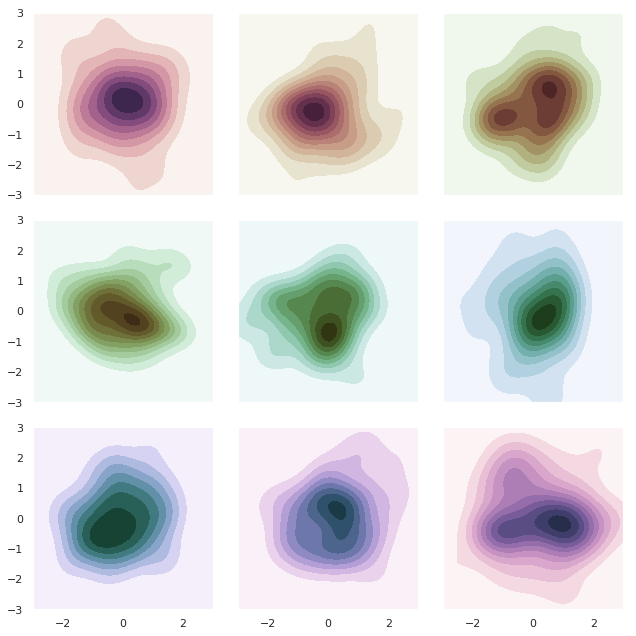

In [3]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="dark")
rs = np.random.RandomState(50)

# Set up the matplotlib figure
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)

# Rotate the starting point around the cubehelix hue circle
for ax, s in zip(axes.flat, np.linspace(0, 3, 10)):

    # Create a cubehelix colormap to use with kdeplot
    cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)

    # Generate and plot a random bivariate dataset
    x, y = rs.randn(2, 50)
    sns.kdeplot(x, y, cmap=cmap, shade=True, cut=5, ax=ax)
    ax.set(xlim=(-3, 3), ylim=(-3, 3))

f.tight_layout()

# Bivariate Distribution

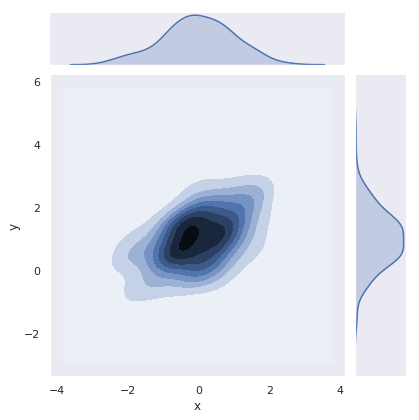

In [11]:
mean, cov = [0, 1], [(1, .5), (.5, 1)]
data = np.random.multivariate_normal(mean, cov, 200)
df = pd.DataFrame(data, columns=["x", "y"])
sns.jointplot(x="x", y="y", data=df, kind="kde");
sns.kdeplot(df.x, df.y, ax=ax)


In [59]:
import os
import ipywidgets as widgets

import bqplot.pyplot as plt
from bqplot import *

In [98]:
image_path = os.path.abspath('KDE.png')

from bqplot import Image

with open(image_path, 'rb') as f:
    raw_image = f.read()
ipyimage = widgets.Image(value=raw_image, format='png')
scales = {'x': LinearScale(), 'y': LinearScale()}
image = Image(image=ipyimage, scales=scales)
fig = Figure(marks=[image], padding_x=0, padding_y=0, animation_duration=1000)
fig.axes = [Axis(scale=scales['x']), Axis(scale=scales['y'], orientation='vertical')]
fig


Figure(animation_duration=1000, axes=[Axis(scale=LinearScale()), Axis(orientation='vertical', scale=LinearScal…

In [100]:
from bqplot import DateScale, LinearScale, OrdinalScale, Axis, Lines, Scatter, Bars, Hist, Figure
from bqplot.interacts import (
    FastIntervalSelector, IndexSelector, BrushIntervalSelector,
    BrushSelector, MultiSelector, LassoSelector, PanZoom, HandDraw
)
from traitlets import link

from ipywidgets import ToggleButtons, VBox, HTML

#multi_sel = MultiSelector(scale=dt_x, marks=[lc2, lc3])
#br_intsel = BrushIntervalSelector(scale=lc1_x, marks=[lc2, lc3])
#index_sel = IndexSelector(scale=dt_x, marks=[lc2, lc3])
int_sel = FastIntervalSelector(scale=LinearScale(), marks=fig.marks, color='FireBrick')


from collections import OrderedDict
selection_interacts = ToggleButtons(options=OrderedDict([#('HandDraw1', hd), ('HandDraw2', hd2), ('PanZoom', pz), 
                                                       ('FastIntervalSelector', int_sel),# ('IndexSelector', index_sel),
                                                       #('BrushIntervalSelector', br_intsel), ('MultiSelector', multi_sel),
                                                       ('None', None)]))

deb = HTML()


link((selection_interacts, 'value'), (fig, 'interaction'))
VBox([fig, selection_interacts, deb], align_self='stretch')

TraitError: Invalid selection: value not found

In [80]:
from ipywidgets import ToggleButtons, VBox, HTML, Layout

#fig = plt.figure(padding_x=0, padding_y=0)
#image = plt.imshow(ipyimage, 'widget')
b = HTML()

A = VBox([fig,b])

In [82]:
fig.marks

[Image(image=Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x014\x08\x02\x00\x00\x00\x19\x9a\x99\xd4\x0...'), interactions={'hover': 'tooltip'}, scales={'x': LinearScale(), 'y': LinearScale()}, scales_metadata={'x': {'orientation': 'horizontal', 'dimension': 'x'}, 'y': {'orientation': 'vertical', 'dimension': 'y'}}, tooltip_style={'opacity': 0.9})]

In [71]:
pdir(fig.interaction)

abstract class:
    __subclasshook__
attribute access:
    __delattr__, __dir__, __getattribute__, __setattr__
class customization:
    __init_subclass__
object customization:
    __del__, __format__, __hash__, __init__, __new__, __repr__, __sizeof__, __str__
pickle:
    __getstate__, __reduce__, __reduce_ex__, __setstate__
property:
    _cross_validation_lock, _holding_sync, _ipython_display_, _model_id, _trait_default_generators, _trait_notifiers, _trait_validators, _trait_values, _widget_construction_callback, types, widget_types, widgets
rich comparison:
    __eq__, __ge__, __gt__, __le__, __lt__, __ne__
special attribute:
    __class__, __dict__, __doc__, __module__, __weakref__
descriptor:
    _call_widget_constructed: class staticmethod with getter, staticmethod(function) -> method
    _comm_changed: class ObserveHandler with getter
    _default_keys: class DefaultHandler with getter
    _display_callbacks: class Instance with getter, setter, A trait whose value must be an insta

In [70]:
pdir(myp.fig.interaction)

abstract class:
    __subclasshook__
attribute access:
    __delattr__, __dir__, __getattribute__, __setattr__
class customization:
    __init_subclass__
object customization:
    __del__, __format__, __hash__, __init__, __new__, __repr__, __sizeof__, __str__
pickle:
    __getstate__, __reduce__, __reduce_ex__, __setstate__
property:
    _cross_validation_lock, _holding_sync, _ipython_display_, _model_id, _trait_default_generators, _trait_notifiers, _trait_validators, _trait_values, _widget_construction_callback, types, widget_types, widgets
rich comparison:
    __eq__, __ge__, __gt__, __le__, __lt__, __ne__
special attribute:
    __class__, __dict__, __doc__, __module__, __weakref__
descriptor:
    _call_widget_constructed: class staticmethod with getter, staticmethod(function) -> method
    _comm_changed: class ObserveHandler with getter
    _default_keys: class DefaultHandler with getter
    _display_callbacks: class Instance with getter, setter, A trait whose value must be an insta

In [72]:
myp.enabled

['brush']

In [74]:
selection_interacts.value

FastIntervalSelector(color='FireBrick', marks=[Image(image=Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x014\x08\x02\x00\x00\x00\x19\x9a\x99\xd4\x0...'), interactions={'hover': 'tooltip'}, scales={'x': LinearScale(), 'y': LinearScale()}, scales_metadata={'x': {'orientation': 'horizontal', 'dimension': 'x'}, 'y': {'orientation': 'vertical', 'dimension': 'y'}}, tooltip_style={'opacity': 0.9})], scale=LinearScale())

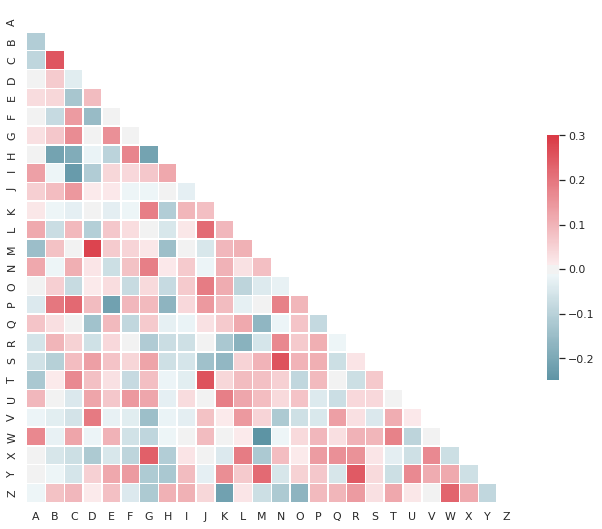

In [2]:

from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})